**Current status**

- Done EDA
- Done feature engineer, stats & ML model

**To do**

- Build dashboard to visualize pattern, statistical description, model evaluation
- Try diagnose some hypothesis to perform stattistical inference
- Feature engineer more as possible (use opensource package, time-series checkpoint)
- Use AutoML, nixtla integrated ML model, restructure ML performance
- Build deep learning model:
    - RNN, LSTM, GRU
    - pre-trained model
    - bidirectional model
- Build LLM model: ollama TimeGPT (nixtla), TimeFM (google), Chronos (amazon), Lag-Llama, Time-LLM, Moirai, iTransformer

https://github.com/Nixtla/nixtla/tree/main/experiments

- Deploy (local streamlit, FastAPI)
    - Choose product to perform result forecast
    - Input data time-series

# Config

In [1]:
%%capture
!pip install pyspark ray
# !pip install pywavelets
# ! pip install pmdarima
# !pip install sktime
# !pip install auto_ts
# !pip install prophet
# !pip install -qqq greykite

!pip install ipython-autotime
%load_ext autotime
# %unload_ext autotime

# Install ipython-sql
# !pip install ipython-sql
# %load_ext sql
# # Execute SQL commands to create a table, insert data, and run a query
# %%sql
# CREATE TABLE test_table(name, age);
# INSERT INTO test_table VALUES('Alice', 24);
# SELECT * FROM test_table;

time: 339 µs (started: 2025-03-02 10:51:15 +00:00)


In [2]:
import sys
sys.stdout.fileno = lambda: False

# Ray Cluster Setup
import ray
runtime_env = {"pip": ["prophet","statsforecast"]}

try:
  ray.init(address='auto', runtime_env=runtime_env, ignore_reinit_error=True)
except:
  ray.init(ignore_reinit_error=True)
print(ray.cluster_resources())

@ray.remote
def test():
    return 12
ray.get([test.remote() for i in range(12)])

2025-03-02 10:51:19,461	INFO worker.py:1841 -- Started a local Ray instance.


{'node:__internal_head__': 1.0, 'CPU': 2.0, 'object_store_memory': 3974971392.0, 'node:172.28.0.12': 1.0, 'memory': 7949942784.0, 'accelerator_type:T4': 1.0, 'GPU': 1.0}


[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]

time: 6.79 s (started: 2025-03-02 10:51:15 +00:00)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import os
import warnings
warnings.filterwarnings("ignore")

from dateutil.relativedelta import relativedelta
from scipy.stats import linregress
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from tqdm import tqdm
from datetime import datetime
import math

import pyspark
import pyspark.sql as pyspark_sql
import pyspark.sql.types as T
import pyspark.sql.functions  as F
from pyspark.sql.window import Window
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, DataFrame
import pyspark.pandas as ps

# ps.set_option('display.max_columns', None)
# ps.set_option('compute.ops_on_diff_frames', True)
# ps.set_option('display.max_rows', 60)

spark = SparkSession.builder.master("local[*]")\
        .getOrCreate()
        # .config(conf = SparkConf().setAll([("spark.scheduler.mode","FAIR")]))\

# windowSpec  = Window.partitionBy("DEPARTMENT").orderBy("SALARY")
# spark.sparkContext.getConf().getAll()
spark.conf.set(
    "spark.sql.execution.arrow.pyspark.fallback.enabled", "true"
)
spark

time: 9.93 s (started: 2025-03-02 10:51:22 +00:00)


In [26]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error as MAE,\
                            mean_squared_error as MSE,\
                            root_mean_squared_error as RMSE,\
                            mean_absolute_percentage_error as MAPE, \
                            r2_score

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL, seasonal_decompose

def evaluate_performance(ground_truth, predicted_values):
    print("MAE", MAE(ground_truth, predicted_values))
    print("RMSE", RMSE(ground_truth, predicted_values))
    print("MSE", MSE(ground_truth, predicted_values))
		# use log when scale of target values is very large
    print("MAPE", MAPE(ground_truth, predicted_values))
    print("R2_score", r2_score(ground_truth, predicted_values))


def accuracy_check(
        df_group: pd.DataFrame,
        key = "overall",
        ground_truth = "SELL",
        predict_col_arr = None,
        start_date = "2016-01-01",
        end_date = "2016-05-22",
):
    df_group[ground_truth] = df_group[ground_truth].fillna(0)

    performance = dict()
    performance = {"CATEGORY": key, "Sum_actual": df_group[ground_truth].sum()}
    performance["Mean_actual"] = df_group[ground_truth].mean()
    performance["Std_actual"] = df_group[ground_truth].std()

    for predict_col in predict_col_arr:
        df_group[predict_col] = df_group[predict_col].fillna(0)
        df_group[predict_col] = df_group[predict_col].replace([-np.inf, np.inf], 0)

        performance["Sum_predict_" + predict_col] = df_group[predict_col].sum()
        performance["Mean_predict_" + predict_col] = df_group[predict_col].mean()
        performance["MAE_" + predict_col] = MAE(
            df_group[ground_truth], df_group[predict_col]
        )
        performance["RMSE_" + predict_col] = RMSE(
            df_group[ground_truth], df_group[predict_col]
        )
        performance["MAPE_" + predict_col] = MAPE(
            df_group[ground_truth], df_group[predict_col]
        )

    return performance


def plot_performance(
        df: pd.DataFrame,
        ground_truth: str = "SELL",
        date_col: str = "DATE",
        predict_col_arr = None,
        start_date = "2016-01-01",
        end_date = "2016-05-22"
):
    df = df[df[date_col].between(start_date, end_date)]
    df[ground_truth] = df[ground_truth].fillna(0)

    for pred in predict_col_arr:
        df[pred] = df[pred].replace([-np.inf, np.inf]).fillna(0)
        print(ground_truth, " vs ", pred)
        evaluate_performance(df[ground_truth], df[pred])

    fig = go.Figure(
        data = [
            go.Scatter(
                x = df[date_col],
                y = df[ground_truth],
                name = "Actual Sell",
                connectgaps = False,
                marker = {"color": "blue"},
                mode = "lines+markers",
            )
        ]
    )
    for pred in predict_col_arr:
        fig.add_trace(
            go.Scatter(x = df[date_col], y = df[pred], name = "Predicted Sell from" + pred)
        )

    fig.update_layout(title="Line chart of actual vs forecast Sell", hovermode= "x unified")
    fig.show()

def plot_decomposition(df, start_date = "2011-01-01", end_date = "2016-12-31", period = 7):
    df = df[df["DATE"].between(start_date, end_date)]
    ts = df.set_index("DATE").asfreq("D")["SELL"]

    ma_decompose = seasonal_decompose(ts, model='additive', period=period)
    ma_decompose.plot()
    plt.legend(title = "Additive Seasonal decomposition")

    ma_decompose = seasonal_decompose(ts, model='multiplicative', period=period)
    ma_decompose.plot()
    plt.legend(title = "Multiplicative Seasonal decomposition")

    loess_decompose = STL(ts, seasonal = period).fit()
    loess_decompose.plot()
    plt.legend(title = "LOESS decomposition")
    plt.show()

def test_stationary(df, series = 'SELL', windowsize=7):
    # Rolling statistics
    movingAverage = df[series].rolling(window=windowsize).mean()
    movingSTD = df[series].rolling(window=windowsize).std()

    fig = go.Figure(
        data = [
            go.Scatter(x = df['DATE'], y = df[series], mode = 'lines',
                    name = series, line = dict(color = 'blue')),
            go.Scatter(x = df['DATE'], y = movingAverage, mode='lines',
                            name = 'Rolling Mean', line = dict(color = 'red')),
            go.Scatter(x = df['DATE'], y = movingSTD, mode = 'lines',
                    name = 'Rolling Std', line = dict(color = 'black'))
        ]
    )
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='Sale')
    fig.update_layout(title='Rolling Mean & Standard Deviation')
    fig.show()

    # Dickey Fuller test
    print('Results of Dickey Fuller Test:\n')
    stable_test = adfuller(df[series], autolag='AIC')
    df_test = pd.Series(stable_test [0:4],
                        index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
    for key, value in stable_test[4].items():
        df_test['Critical Value (%s)' %key] = value
    print(df_test)

    # Hypothesis Testing
    if stable_test[0] < stable_test[4]['5%']:
        print('Reject Ho — Time Series is Stationary!')
    else:
        print('Accept Ho — Time Series is not Stationary!')

time: 12.8 ms (started: 2025-03-02 10:58:21 +00:00)


# Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.75 s (started: 2025-03-02 10:51:32 +00:00)


In [6]:
# import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/Capstone project m5 forecast/preprocess_data.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/data/")

# df_product = spark.read.format("csv").options(header = True).load("/content/data/")

# df_product = df_product.withColumn("SELL", F.col("SELL").cast("float"))\
#                        .withColumn("SELL_PRICE", F.col("SELL_PRICE").cast("float"))\
#                        .withColumn("DATE", F.to_date(F.col("date")))\
#                        .withColumn("DAY_OF_WEEK", F.col("DAY_OF_WEEK").cast("int"))\
#                        .withColumn("MONTH", F.col("MONTH").cast("int"))\
#                        .withColumn("YEAR", F.col("YEAR").cast("int"))\
#                        .withColumn("SNAP_CA", F.col("SNAP_CA").cast("int"))\
#                        .withColumn("SNAP_TX", F.col("SNAP_TX").cast("int"))\
#                        .withColumn("SNAP_WI", F.col("SNAP_WI").cast("int"))\
#                        .drop("DATE_INDEX_ITEM")\
#                        .orderBy("ID","ITEM","STORE","DATE")

# df_product.printSchema()

# print(df_product.count(), len(df_product.columns))
# df_product.show(5, truncate = False)

time: 198 µs (started: 2025-03-02 10:51:35 +00:00)


In [7]:
# df_total_result_model = pd.read_csv("/content/drive/MyDrive/Capstone project m5 forecast/df_total_result_model.csv")
# df_total_result_model["DATE"] = pd.to_datetime(df_total_result_model["DATE"], format = "%Y-%m-%d")
# print(df_total_result_model.shape)
# df_total_result_model.head(2)

time: 158 µs (started: 2025-03-02 10:51:35 +00:00)


In [8]:
df_sample = pd.read_csv("/content/drive/MyDrive/Capstone project m5 forecast/top1000_product_sample.csv")
df_sample["DATE"] = pd.to_datetime(df_sample["DATE"])
print(df_sample["DATE"].min(), df_sample["DATE"].max())
df_sample.head()

2011-01-29 00:00:00 2016-05-22 00:00:00


,ID,ITEM,DEPARTMENT,CATEGORY,STORE,STATE,SELL,SELL_PRICE,DATE_INDEX_ITEM,DATE,...,DAY_OF_WEEK,MONTH,YEAR,EVENT_NAME_1,EVENT_TYPE_1,EVENT_NAME_2,EVENT_TYPE_2,SNAP_CA,SNAP_TX,SNAP_WI
0,FOODS_1_004_CA_1_evaluation,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,0.0,NaN,NaN,2011-01-29,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,FOODS_1_004_CA_1_evaluation,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,0.0,NaN,NaN,2011-01-30,...,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,FOODS_1_004_CA_1_evaluation,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,0.0,NaN,NaN,2011-01-31,...,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,FOODS_1_004_CA_1_evaluation,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,0.0,NaN,NaN,2011-02-01,...,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,FOODS_1_004_CA_1_evaluation,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,0.0,NaN,NaN,2011-02-02,...,5,2,2011,NaN,NaN,NaN,NaN,1,0,1


time: 5.19 s (started: 2025-03-02 10:51:35 +00:00)


# Deep Learning

## Nixtla framework

https://nixtlaverse.nixtla.io/neuralforecast/models.html

In [9]:
%%capture
!pip install neuralforecast

time: 2.62 s (started: 2025-03-02 10:51:40 +00:00)


In [10]:
import torch

df_model = df_sample.copy()
df_model = df_model.rename(columns= {
    'ID':"unique_id",
    'DATE': "ds",
    "SELL":"y",
})

# df_model = df_model[
#     df_model["unique_id"].isin(df_model["unique_id"].unique()[:1])
# ]

df_train = df_model[df_model["ds"] < "2016-01-01"]
df_test = df_model[df_model["ds"] >= "2016-01-01"]

df_train.shape, df_test.shape

((1798000, 21), (143000, 21))

time: 9.05 s (started: 2025-03-02 10:51:43 +00:00)


In [11]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, PatchTST

from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, mse

fc_horizon = 143

models = [NHITS(h=fc_horizon,
               input_size=2*fc_horizon,
               max_steps=50),
         NBEATS(h=fc_horizon,
               input_size=2*fc_horizon,
               max_steps=50),
         PatchTST(h=fc_horizon,
                 input_size=2*fc_horizon,
                 max_steps=50)]

nf = NeuralForecast(models=models, freq='D')
nf.fit(df=df_train[["ds","y","unique_id"]], val_size=fc_horizon)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.905    Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.4 M  | train
-------------------------------------------------------
3.3 M     Trainable params
123 K     Non-trainable params
3.4 M     Total params
13.770    Total estimated model params size (MB)
31        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 1.0 M  | train
-----------------------------------------------------------
1.0 M     Trainable params
3         Non-trainable params
1.0 M     Total params
4.180     Total estimated model params size (MB)
90        Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.


time: 32.6 s (started: 2025-03-02 10:51:52 +00:00)


In [12]:
preds_df = nf.predict()
preds_df.head(3)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,NHITS,NBEATS,PatchTST
0,FOODS_1_004_CA_1_evaluation,2016-01-01,5.973251,4.949571,8.889666
1,FOODS_1_004_CA_1_evaluation,2016-01-02,6.376646,5.261841,10.417086
2,FOODS_1_004_CA_1_evaluation,2016-01-03,6.147754,3.663115,5.427552


time: 876 ms (started: 2025-03-02 10:54:25 +00:00)


In [24]:
df_eval = df_test[["unique_id","ds","y"]]

df_eval = df_eval.merge(
    preds_df,
    on = ["unique_id","ds"],
    how = "left"
)
df_eval.describe()

,ds,y,NHITS,NBEATS,PatchTST
count,143000,143000.000000,143000.000000,143000.000000,143000.000000
mean,2016-03-12 00:00:00,11.120273,11.078058,10.577312,10.712056
min,2016-01-01 00:00:00,0.000000,-3.929460,-6.295414,-9.179166
25%,2016-02-05 00:00:00,3.000000,3.626752,3.503851,5.117831
50%,2016-03-12 00:00:00,8.000000,8.050863,7.736176,8.271277
75%,2016-04-17 00:00:00,14.000000,14.166173,13.474137,12.938879
max,2016-05-22 00:00:00,248.000000,137.197876,156.319443,125.648041
std,NaN,13.000131,11.832900,11.573940,10.040282


time: 70.2 ms (started: 2025-03-02 10:58:05 +00:00)


In [28]:
display(accuracy_check(df_eval, ground_truth = "y", predict_col_arr = ["NHITS","NBEATS","PatchTST"]))

plot_temp = df_eval.groupby("ds").agg({
    "y":"sum",
    "NHITS":"sum",
    "NBEATS":"sum",
    "PatchTST":"sum"
}).reset_index()
plot_performance(plot_temp, ground_truth = "y", date_col = "ds", predict_col_arr = ["NHITS","NBEATS","PatchTST"])

{'CATEGORY': 'overall',
 'Sum_actual': 1590199.0,
 'Mean_actual': 11.120272727272727,
 'Std_actual': 13.00013110013827,
 'Sum_predict_NHITS': 1584162.4,
 'Mean_predict_NHITS': 11.078058,
 'MAE_NHITS': 7.653640714426369,
 'RMSE_NHITS': 12.282617592536084,
 'MAPE_NHITS': 4293643964998247.5,
 'Sum_predict_NBEATS': 1512555.6,
 'Mean_predict_NBEATS': 10.577312,
 'MAE_NBEATS': 7.287581434202361,
 'RMSE_NBEATS': 11.796863008894064,
 'MAPE_NBEATS': 3772138415237551.0,
 'Sum_predict_PatchTST': 1531824.0,
 'Mean_predict_PatchTST': 10.712056,
 'MAE_PatchTST': 6.233650612067197,
 'RMSE_PatchTST': 9.733213155271839,
 'MAPE_PatchTST': 4417506481068508.5}

y  vs  NHITS
MAE 1293.7612065668707
RMSE 1581.0743592883198
MSE 2499796.129598971
MAPE 0.1168957043683909
R2_score 0.2999678470490613
y  vs  NBEATS
MAE 1355.4204203999127
RMSE 1709.189332953491
MSE 2921328.1758819995
MAPE 0.11664708604127334
R2_score 0.1819238264174019
y  vs  PatchTST
MAE 952.9206184440559
RMSE 1228.1289669141179
MSE 1508300.7593735382
MAPE 0.08236295215980534
R2_score 0.5776219446938741


time: 417 ms (started: 2025-03-02 10:58:50 +00:00)


## Prophet

In [ ]:
from prophet import Prophet

@ray.remote
def prophet_training(key, df_group, fc_horizon = 30):
    # df_group["PROPHET"] = np.nan
    df_group["ERROR_PROPHET"] = np.nan
    df_group["DATE"] = pd.to_datetime(df_group["DATE"])

    df_train = df_group[df_group["DATE"] < "2016-01-01"][["DATE", "SELL"]]
    df_train.columns = ["ds", "y"]

    # df_test = df_group[df_group["DATE"] >= "2016-01-01"][["DATE","exo_columns"]]
    # df_test.columns = ["ds","exo_columns"]
    try:
        model = Prophet()
        model = model.fit(df_train)
        df_test = model.make_future_dataframe(fc_horizon, include_history=False, freq="D")
        df_pred = model.predict(df_test)
        df_pred = df_pred[["ds", "yhat"]]
        # set ds to first day of month
        # df_pred["ds"] = df_pred["ds"] - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)
        df_group = df_group.merge(
            df_pred, left_on="DATE", right_on="ds", how="left"
        )
    except Exception as e:
        df_group["ERROR_PROPHET"] = str(e)
    return df_group

TASKS_LIST = [prophet_training.remote(key, df_group, 143) for key, df_group in df_sample.groupby('ID')]
TASKS_LIST = ray.get(TASKS_LIST)
df_result = pd.concat(TASKS_LIST)

df_result.describe()

(prophet_training pid=1386) 10:31:00 - cmdstanpy - INFO - Chain [1] start processing
(prophet_training pid=1386) 10:31:06 - cmdstanpy - INFO - Chain [1] done processing
(prophet_training pid=1387) 10:31:01 - cmdstanpy - INFO - Chain [1] start processing
(prophet_training pid=1386) 10:31:07 - cmdstanpy - INFO - Chain [1] start processing
(prophet_training pid=1387) 10:31:11 - cmdstanpy - INFO - Chain [1] done processing [repeated 10x across cluster]
(prophet_training pid=1387) 10:31:12 - cmdstanpy - INFO - Chain [1] start processing [repeated 10x across cluster]
(prophet_training pid=1387) 10:31:16 - cmdstanpy - INFO - Chain [1] done processing [repeated 9x across cluster]
(prophet_training pid=1387) 10:31:17 - cmdstanpy - INFO - Chain [1] start processing [repeated 11x across cluster]
(prophet_training pid=1386) 10:31:21 - cmdstanpy - INFO - Chain [1] done processing [repeated 13x across cluster]
(prophet_training pid=1387) 10:31:22 - cmdstanpy - INFO - Chain [1] start processing [repe

In [24]:
df_eval = df_result[df_result["DATE"] >= "2016-1-1"][["ID","DATE","SELL","yhat"]]
df_eval = df_eval.rename(columns = {"yhat":"PROPHET"})
df_eval.describe()

,DATE,SELL,PROPHET
count,143000,143000.000000,143000.000000
mean,2016-03-12 00:00:00,11.120273,10.084313
min,2016-01-01 00:00:00,0.000000,-23.333903
25%,2016-02-05 00:00:00,3.000000,4.460292
50%,2016-03-12 00:00:00,8.000000,8.188835
75%,2016-04-17 00:00:00,14.000000,13.133222
max,2016-05-22 00:00:00,248.000000,140.543238
std,NaN,13.000131,10.400890


time: 436 ms (started: 2025-03-02 10:41:13 +00:00)


In [26]:
display(accuracy_check(df_eval, ground_truth = "SELL", predict_col_arr = ["PROPHET"]))

plot_temp = df_eval.groupby("DATE").agg({
    "SELL":"sum",
    "PROPHET":"sum"
}).reset_index()
plot_performance(plot_temp, ground_truth = "SELL", date_col = "DATE", predict_col_arr = ["PROPHET"])

{'CATEGORY': 'overall',
 'Sum_actual': 1590199.0,
 'Mean_actual': 11.120272727272727,
 'Std_actual': 13.00013110013827,
 'Sum_predict_PROPHET': 1442056.7765886185,
 'Mean_predict_PROPHET': 10.084313122997333,
 'MAE_PROPHET': 6.852423658576429,
 'RMSE_PROPHET': 10.554494607394412,
 'MAPE_PROPHET': 5153326555850095.0}

SELL  vs  PROPHET
MAE 1120.7085773455574
RMSE 1360.1735488041331
MSE 1850072.0828664294
MAPE 0.09750880761114272
R2_score 0.48191377370794575


time: 689 ms (started: 2025-03-02 10:41:25 +00:00)


# LLM for time-series


In [11]:
import torch

df_model = df_sample.copy()
df_model = df_model.rename(columns= {
    'ID':"unique_id",
    'DATE': "ds",
    "SELL":"y",
})

# df_model = df_model[
#     df_model["unique_id"].isin(df_model["unique_id"].unique()[:1])
# ]

df_train = df_model[df_model["ds"] < "2016-01-01"]
df_test = df_model[df_model["ds"] >= "2016-01-01"]

df_train.shape, df_test.shape

((1798000, 21), (143000, 21))

time: 14.7 s (started: 2025-03-02 09:55:04 +00:00)


## TimeGPT (nixtla)

In [ ]:
%%capture
%pip install nixtla

time: 3.33 s (started: 2025-02-08 12:31:23 +00:00)


In [ ]:
from nixtla import NixtlaClient
from nixtla.date_features import CountryHolidays
from nixtla.date_features import SpecialDates
import pandas as pd
from google.colab import userdata

# Initialize the TimeGPT client with your API key
nixtla_client = NixtlaClient(api_key=userdata.get('NIXTLA_API_KEY'))
nixtla_client.validate_api_key()

True

time: 6.66 s (started: 2025-02-08 12:32:03 +00:00)


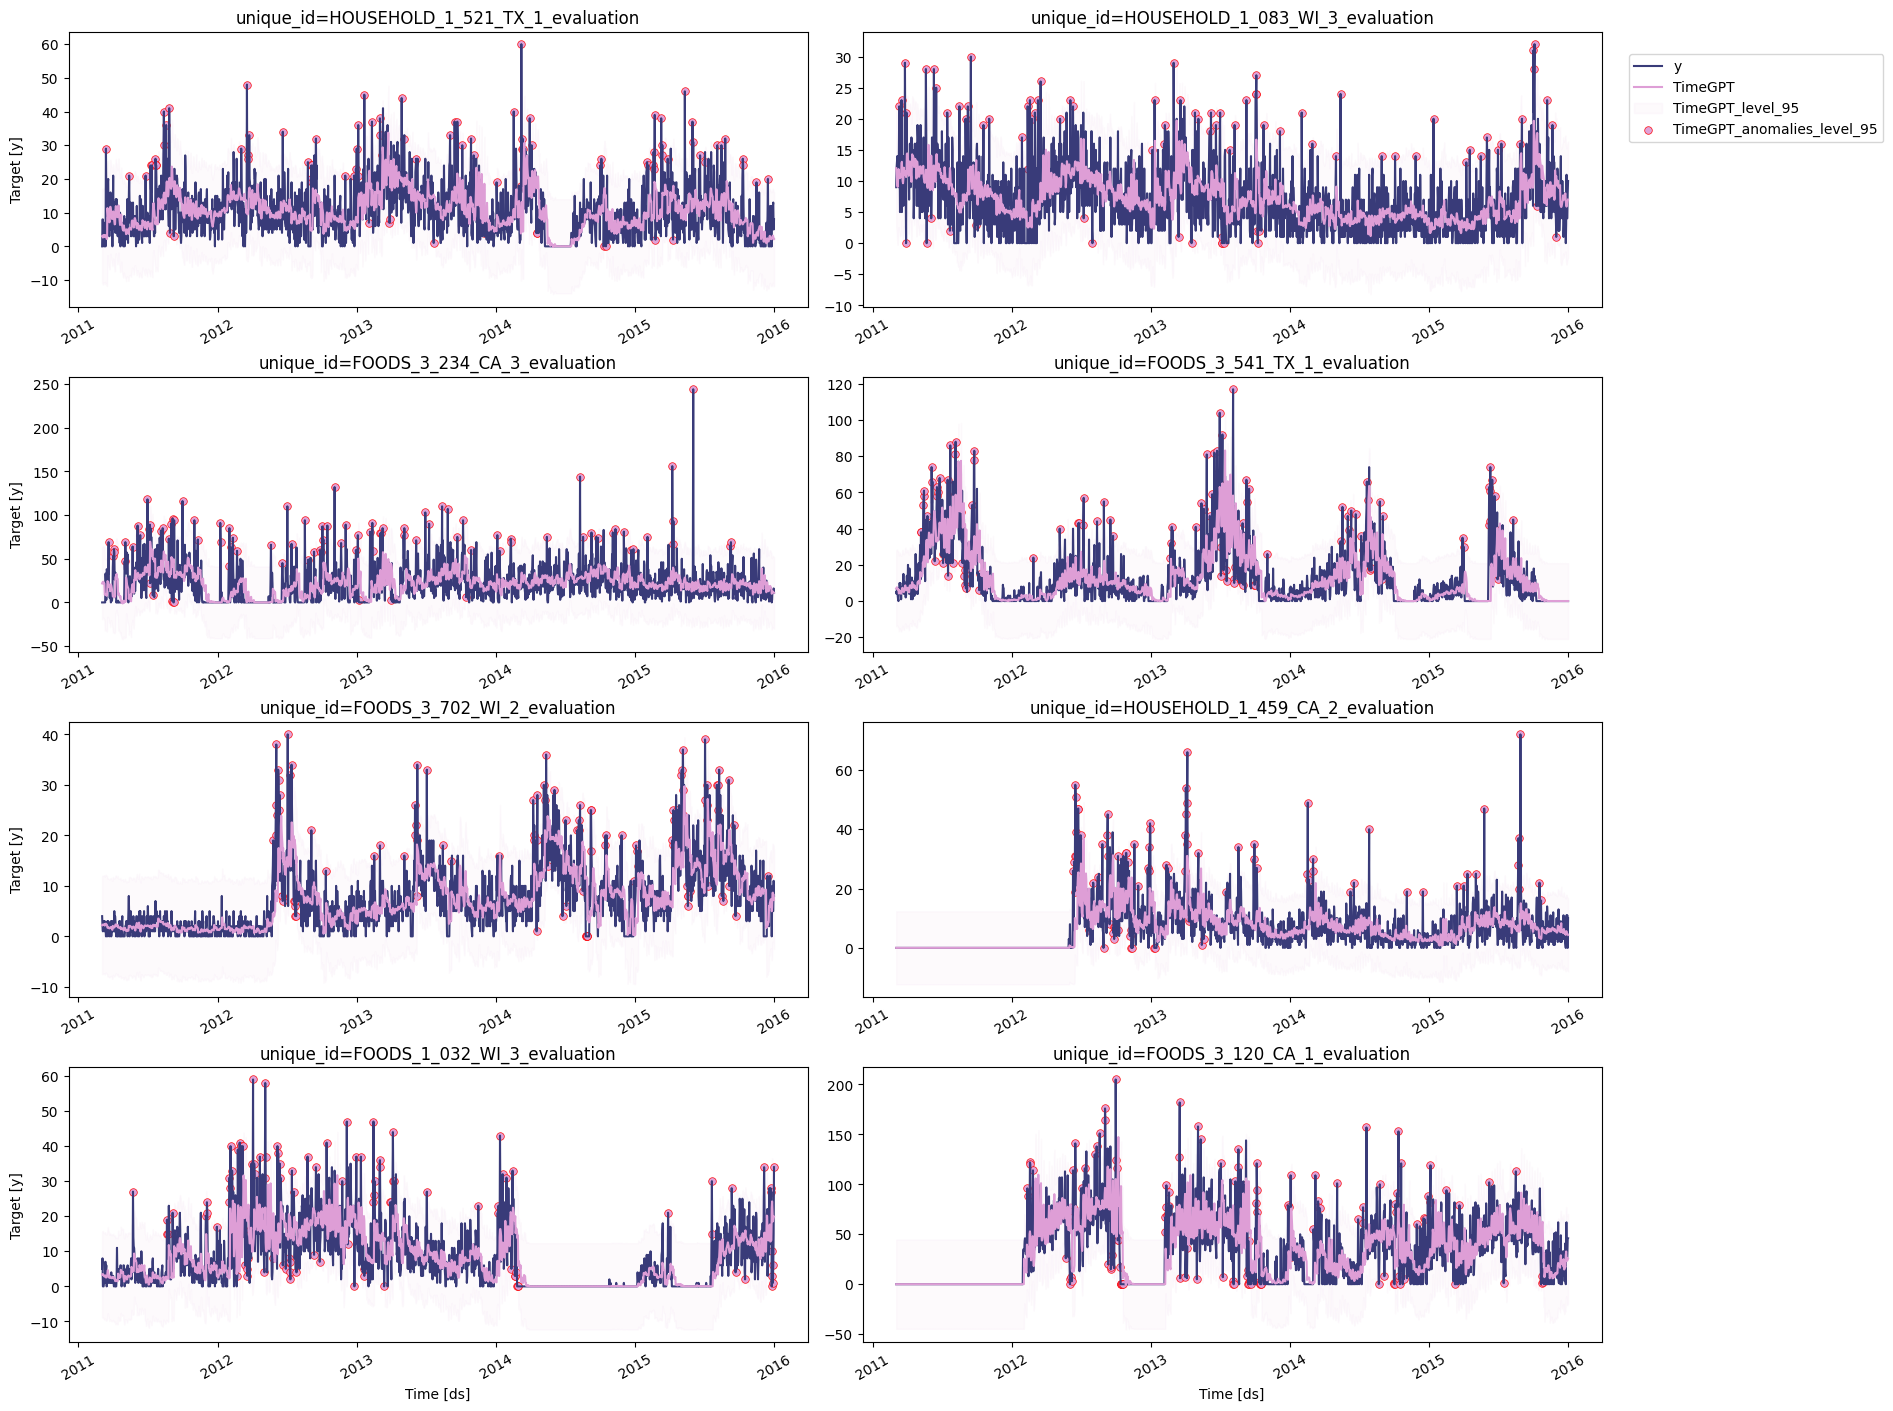

time: 19.2 s (started: 2025-02-08 12:33:53 +00:00)


In [ ]:
# Detect anomalies
anomalies_df = nixtla_client.detect_anomalies(
    df=df_train[["ds","y","unique_id"]],
    time_col='ds',
    target_col='y',
    id_col='unique_id',
    level=95,
)

# Plot anomalies
nixtla_client.plot(df_train, anomalies_df)

In [ ]:
df_test.drop(["y"], axis =1).head(2)

,unique_id,ITEM,DEPARTMENT,CATEGORY,STORE,STATE,SELL_PRICE,DATE_INDEX_ITEM,ds,WEEK_DAY,DAY_OF_WEEK,MONTH,YEAR,EVENT_NAME_1,EVENT_TYPE_1,EVENT_NAME_2,EVENT_TYPE_2,SNAP_CA,SNAP_TX,SNAP_WI
1798,FOODS_1_004_CA_1_evaluation,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,1.96,NaN,2016-01-01,Friday,7,1,2016,NewYear,National,NaN,NaN,1,1,0
1799,FOODS_1_004_CA_1_evaluation,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,1.96,NaN,2016-01-02,Saturday,1,1,2016,NaN,NaN,NaN,NaN,1,0,1


time: 169 ms (started: 2025-02-08 13:07:21 +00:00)


In [ ]:
# Generate forecasts with 50 fine-tuning steps
timegpt_model = nixtla_client.forecast(
    df=df_train,
    h=143,
    finetune_steps=365, # model will go through number iterations of training on your time series data.
    finetune_depth = 3, # number of last layer to fine-tune model [1 -> 5]
    finetune_loss = "rmse",
    id_col='unique_id',
    model='timegpt-1-long-horizon',
    target_col='y',
    time_col='ds',
    # X_df = df_test[["unique_id","ds","SELL_PRICE","DAY_OF_WEEK","MONTH","YEAR","SNAP_CA","SNAP_TX","SNAP_WI"]] # exo variable of future
    # add_history=True,
    # hist_exog_list=["SELL_PRICE"]
)
print(MAE(df_test['y'], timegpt_model["TimeGPT"]))
print(RMSE(df_test['y'], timegpt_model["TimeGPT"]))

6.170309353878845
9.865015062460119
time: 10.3 ms (started: 2025-02-08 13:17:20 +00:00)


In [ ]:
df_eval = df_test[["unique_id","ds","y"]]
df_eval = df_eval.merge(
    timegpt_model[["unique_id","ds","TimeGPT"]],
    on = ["unique_id","ds"],
    how = "left"
)
df_eval.describe()

,ds,y,TimeGPT
count,143000,143000.000000,143000.000000
mean,2016-03-12 00:00:00,11.120273,10.015982
min,2016-01-01 00:00:00,0.000000,-4.324259
25%,2016-02-05 00:00:00,3.000000,4.970773
50%,2016-03-12 00:00:00,8.000000,7.553803
75%,2016-04-17 00:00:00,14.000000,11.668160
max,2016-05-22 00:00:00,248.000000,126.482290
std,NaN,13.000131,9.197244


time: 117 ms (started: 2025-02-08 13:17:25 +00:00)


In [ ]:
display(accuracy_check(df_eval, ground_truth = "y", predict_col_arr = ["TimeGPT"]))

# plot_temp = df_eval[df_eval["ID"] == "FOODS_1_218_TX_2_evaluation"]
plot_temp = df_eval.groupby("ds").agg({
    "y":"sum",
    "TimeGPT":"sum"
}).reset_index()
plot_performance(plot_temp, ground_truth = "y", date_col = "ds", predict_col_arr = ["TimeGPT"])

{'CATEGORY': 'overall',
 'Sum_actual': 1590199.0,
 'Mean_actual': 11.120272727272727,
 'Std_actual': 13.00013110013827,
 'Sum_predict_TimeGPT': 1432285.3685382402,
 'Mean_predict_TimeGPT': 10.015981598169512,
 'MAE_TimeGPT': 6.170309353878845,
 'RMSE_TimeGPT': 9.865015062460119,
 'MAPE_TimeGPT': 4462203733717066.0}

y  vs  TimeGPT
MAE 1235.4532681696599
RMSE 1553.674059197448
MSE 2413903.0822230754
MAPE 0.1030332944991478
R2_score 0.32402096648792966


time: 53.8 ms (started: 2025-02-08 13:17:26 +00:00)


## TimesFM (google)

reference: https://huggingface.co/google/timesfm-1.0-200m

https://github.com/google-research/timesfm

In [ ]:
%%capture
!pip install timesfm[torch]

time: 4min 33s (started: 2025-02-09 12:18:26 +00:00)


In [ ]:
import timesfm

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0].
time: 18.5 s (started: 2025-02-09 09:42:29 +00:00)


### zero shot predict

In [ ]:
# Define hyperparameters
# hparams = {
#     "context_len": 128,        # Length of the context window for the model
#     "horizon_len": 142,        # Forecasting horizon length
#     "input_patch_len": 32,     # Length of input patches
#     "output_patch_len": 128,   # Length of output patches
#     "num_layers": 20,          # Number of layers in the model
#     "model_dims": 1280,        # Dimensions of the model
# }

# # Loading the timesfm-2.0 checkpoint:
# tfm = timesfm.TimesFm(
#       hparams=timesfm.TimesFmHparams(
#           backend="gpu",
#           per_core_batch_size=32,
#           horizon_len=128,
#           num_layers=50,
#           use_positional_embedding=False,
#           context_len=2048,
#       ),
#       checkpoint=timesfm.TimesFmCheckpoint(
#           huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
#   )

# Loading the timesfm-1.0 checkpoint:
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
        backend="gpu",
        per_core_batch_size=32,
        horizon_len=143,
        # num_layers=50,
        # context_len=2048,
        # use_positional_embedding=False,
      ),
    # google/timesfm-2.0-500m-pytorch
    # google/timesfm-1.0-200m-pytorch
      checkpoint=timesfm.TimesFmCheckpoint(huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
  )

# Load data and forecast
timesfm_forecast = tfm.forecast_on_df(
    inputs=df_train,     # Input training data for training
    freq="D",            # Frequency of the time-series data
    value_name="y",      # Name of the column containing the values to be forecasted
    num_jobs=-1,         # Use all available cores for forecasting
)

# Select relevant columns from the forecast
timesfm_forecast = timesfm_forecast[["ds", "timesfm"]]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/5.58k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

torch_model.ckpt:   0%|          | 0.00/814M [00:00<?, ?B/s]

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
time: 5min 10s (started: 2025-02-09 09:50:18 +00:00)


In [ ]:
pred_val = timesfm_forecast['timesfm']
pred_val = np.array(pred_val).astype(float)

df_test["PREDICT"] = pred_val
df_test[["y","PREDICT","ds"]].describe()

,y,PREDICT,ds
count,143000.000000,143000.000000,143000
mean,11.120273,8.601717,2016-03-12 00:00:00
min,0.000000,-8.787819,2016-01-01 00:00:00
25%,3.000000,3.747019,2016-02-05 00:00:00
50%,8.000000,6.668419,2016-03-12 00:00:00
75%,14.000000,10.549600,2016-04-17 00:00:00
max,248.000000,126.350494,2016-05-22 00:00:00
std,13.000131,8.966567,NaN


time: 110 ms (started: 2025-02-09 10:26:51 +00:00)


In [ ]:
display(accuracy_check(df_test, ground_truth = "y", predict_col_arr = ["PREDICT"]))

# plot_temp = df_eval[df_eval["ID"] == "FOODS_1_218_TX_2_evaluation"]
plot_temp = df_test.groupby("ds").agg({
    "y":"sum",
    "PREDICT":"sum"
}).reset_index().rename(columns={"ds":"DATE"})
plot_performance(plot_temp, ground_truth = "y", predict_col_arr = ["PREDICT"])

{'CATEGORY': 'overall',
 'Sum_actual': 1590199.0,
 'Mean_actual': 11.120272727272727,
 'Std_actual': 13.00013110013827,
 'Sum_predict_PREDICT': 1230045.5525842574,
 'Mean_predict_PREDICT': 8.601717150938864,
 'MAE_PREDICT': 6.271084333971625,
 'RMSE_PREDICT': 10.957836676484193,
 'MAPE_PREDICT': 3155517123962544.5}

y  vs  PREDICT
MAE 2540.9235413705414
RMSE 2844.0046973286517
MSE 8088362.718427435
MAPE 0.21920611165249487
R2_score -1.2650302961054698


time: 749 ms (started: 2025-02-09 10:26:54 +00:00)


### finetune

In [ ]:
import os
import torch
import torch.multiprocessing as mp
from timesfm.finetuning_torch import FinetuningConfig, TimesFMFinetuner
from huggingface_hub import snapshot_download
from torch.utils.data import Dataset

from timesfm import TimesFm, TimesFmCheckpoint, TimesFmHparams
from timesfm.pytorch_patched_decoder import PatchedTimeSeriesDecoder

def get_model(load_weights: bool = False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    repo_id = "google/timesfm-1.0-200m-pytorch"
    hparams = TimesFmHparams(
        backend=device,
        per_core_batch_size=32,
        horizon_len=143,
        # num_layers=50,
        # use_positional_embedding=False,
        # context_len= 192,  # Context length can be anything up to 2048 in multiples of 32
    )
    tfm = TimesFm(hparams=hparams,
                    checkpoint=TimesFmCheckpoint(huggingface_repo_id=repo_id))

    model = PatchedTimeSeriesDecoder(tfm._model_config)
    if load_weights:
        checkpoint_path = os.path.join(snapshot_download(repo_id), "torch_model.ckpt")
        loaded_checkpoint = torch.load(checkpoint_path, weights_only=True)
        model.load_state_dict(loaded_checkpoint)
    return model, hparams, tfm._model_config

def single_gpu_example(data):
    """Basic example of finetuning TimesFM on stock data."""
    model, hparams, tfm_config = get_model(load_weights=True)
    config = FinetuningConfig(batch_size=256,
                                num_epochs=5,
                                learning_rate=1e-4,
                                use_wandb=True,
                                freq_type=1,
                                log_every_n_steps=10,
                                val_check_interval=0.5,
                                use_quantile_loss=True)

    finetuner = TimesFMFinetuner(model, config)
    df_train, df_val = train_test_split(data, shuffle = False, test_size =0.3)

    print("\nStarting finetuning...")
    results = finetuner.finetune(train_dataset=df_train,val_dataset=df_val)

    print("\nFinetuning completed!")
    print(f"Training history: {len(results['history']['train_loss'])} epochs")

ModuleNotFoundError: No module named 'timesfm.finetuning_torch'

time: 34.8 ms (started: 2025-02-09 12:23:00 +00:00)


In [ ]:
single_gpu_example(df_train)

## Chronos (amazon)

* chronos-t5-tiny: 8M parameters
* chronos-t5-mini: 20M parameters
* chronos-t5-small: 46M parameters
* chronos-t5-base: 200M parameters
* chronos-t5-large: 710M parameters

In [ ]:
%%capture
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

time: 2min 28s (started: 2025-02-09 14:27:19 +00:00)


In [ ]:
from chronos import ChronosPipeline

time: 24.3 s (started: 2025-02-09 14:29:47 +00:00)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  device_map=device,
#   torch_dtype=torch.float32,
)
device

'cuda'

time: 1.38 s (started: 2025-02-09 14:53:16 +00:00)


In [ ]:
horizon = 143
step = 1
ids = []
ds = []
actual = []
preds = []
for key, df_group in tqdm(df_model.groupby(["unique_id"])):
    for i in range(step):
        ids.extend(key[0])
        ds.extend(df_group['ds'][-horizon:].values)
        actual.extend(df_group['y'][-horizon:].values)

        # Chronos expects a tensor as input
        context = torch.tensor(df_group['y'].iloc[:-horizon].values)

        # Make predictions
        forecast = pipeline.predict(context, horizon)

        # Get median value of predictions
        # You can get predictions intervals by passing a list of percentiles
        # Ex.: 80% interval is [0.1, 0.5, 0.9]
        predictions = np.quantile(forecast[0].numpy(), [0.5], axis=0)

        preds.extend(predictions[0])

        df_result = pd.DataFrame({
            'unique_id': ids,
            'ds': ds,
            'y': actual,
            'chronos': preds
        })

    chronos_pred = pd.concat([chronos_pred, df_result])

100%|██████████| 1000/1000 [24:30<00:00,  1.47s/it]


ValueError: All arrays must be of the same length

time: 24min 30s (started: 2025-02-09 14:55:37 +00:00)


In [ ]:
chronos_pred = results_df.copy()

NameError: name 'results_df' is not defined

time: 25.2 ms (started: 2025-02-09 15:20:08 +00:00)


In [ ]:
df_eval = df_test[["unique_id","ds","y"]]
df_eval = df_eval.merge(
    chronos_pred[["unique_id","ds","chronos"]],
    on = ["unique_id","ds"],
    how = "left"
)
df_eval.describe()

NameError: name 'chronos_pred' is not defined

time: 30.8 ms (started: 2025-02-09 15:20:08 +00:00)


In [ ]:
display(accuracy_check(df_eval, ground_truth = "y", predict_col_arr = ["TimeGPT"]))

# plot_temp = df_eval[df_eval["ID"] == "FOODS_1_218_TX_2_evaluation"]
plot_temp = df_eval.groupby("ds").agg({
    "y":"sum",
    "chronos":"sum"
}).reset_index()
plot_performance(plot_temp, ground_truth = "y", date_col = "ds", predict_col_arr = ["TimeGPT"])